In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from phathom.phenotype import celltype
from phathom import io
from phathom import utils
from phathom import plotting

In [2]:
%matplotlib notebook

In [122]:
working_dir = '/media/jswaney/Drive/Justin/organoid_etango/'

# Set parameters on test images

In [126]:
syto16_path = 'syto16.zarr'

syto16_zarr = io.zarr.open(os.path.join(working_dir, syto16_path))
syto16_zarr.shape

AttributeError: 

In [85]:
# extract test patch
shape = np.array((32, 256, 256))
start = np.array((8, 180, 368))

stop = start + shape

syto16_test = utils.extract_box(syto16_zarr, start, stop)
syto16_test.shape

(32, 256, 256)

In [86]:
sigma = (1.2, 3.0, 3.0)
steepness = 1200
offset = 0.0001

prob = celltype.nucleus_probability(syto16_test, sigma, steepness, offset)

<IPython.core.display.Javascript object>


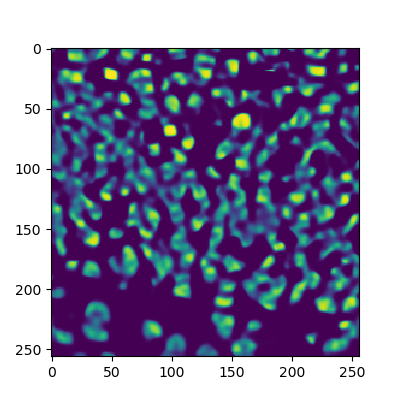

In [92]:
plt.figure(figsize=(4, 4))
plt.imshow(prob[16], clim=[0, 1])
plt.show()

In [93]:
prob_path = 'nuclei_probability.zarr'

prob_output = io.zarr.new_zarr(os.path.join(working_dir, prob_path), 
                               syto16_zarr.shape, 
                               syto16_zarr.chunks,
                               np.float32)

results = celltype.detect_nuclei_parallel(syto16_zarr, 
                                          sigma=(1.2, 3, 3), 
                                          min_intensity=100,
                                          steepness=1200, 
                                          offset=0.0001,
                                          prob_thresh=0.1,
                                          min_dist=2,
                                          chunks=(64, 128, 128),
                                          overlap=8,
                                          nb_workers=None,
                                          prob_output=prob_output)
centers_list = [r for r in results if r is not None]

100%|██████████| 128/128 [01:27<00:00,  1.45it/s]


<IPython.core.display.Javascript object>


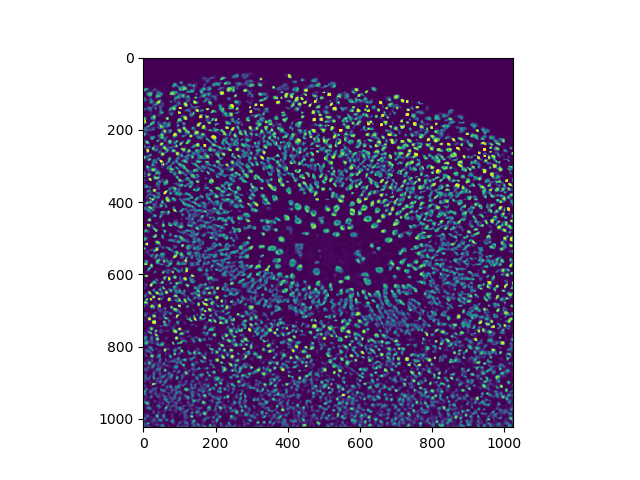

In [111]:
plt.imshow(prob_output[21])  # check that the probability map was saved properly
plt.show()

In [112]:
import tifffile

In [113]:
tifffile.imsave(os.path.join(working_dir, 'prob_map.tif'), prob_output[21].astype(np.float32))

In [119]:
tifffile.imsave(os.path.join(working_dir, 'nuclei_img.tif'), syto16_zarr[21])

In [95]:
centers = np.vstack(centers_list)
centers.shape

(60196, 3)

<IPython.core.display.Javascript object>


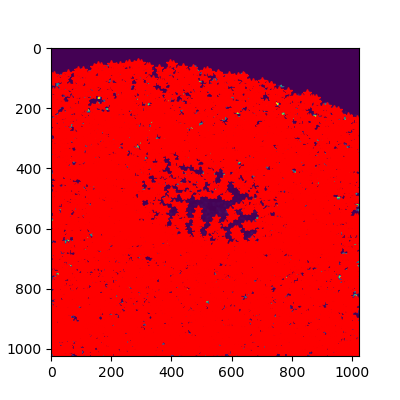

In [109]:
plt.figure(figsize=(4, 4))
plotting.zprojection(syto16_zarr, centers, zlim=[18, 26])

In [114]:
from phathom.synthetic import points_to_binary

In [117]:
centers_img = points_to_binary(tuple(centers.T), syto16_zarr.shape)

In [118]:
tifffile.imsave(os.path.join(working_dir, 'centers.tif'), centers_img)

<IPython.core.display.Javascript object>


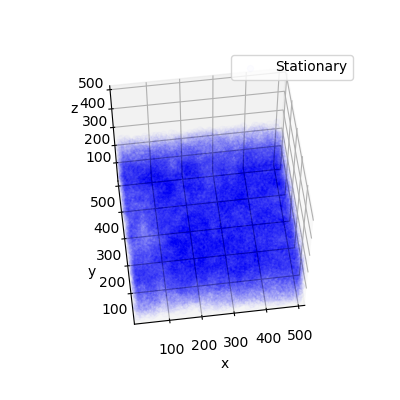

In [12]:
plotting.plot_pts(centers, alpha=0.01)

# Save the nuclei centers

In [14]:
centers_path = 'centers.npy'

np.save(os.path.join(working_dir, centers_path), centers)

In [127]:
data = tifffile.imread(os.path.join(working_dir, 'syto16.tif'))

In [128]:
data.shape

(638, 4424, 4422)

<IPython.core.display.Javascript object>


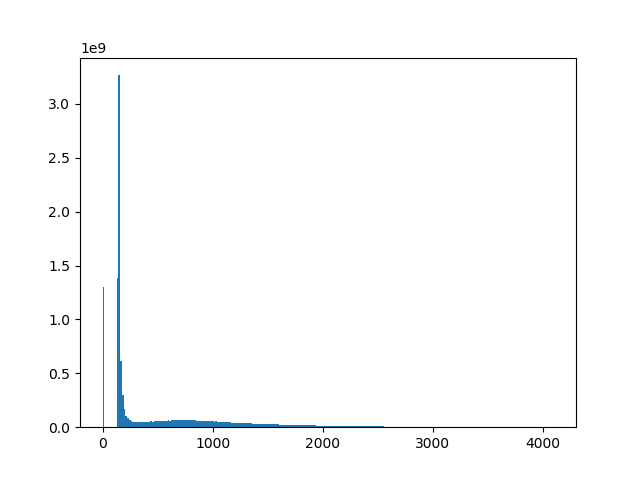

In [129]:
h = plt.hist(data.flatten(), bins=256, range=[0, 4095])
plt.show()